In [3]:
!pip install torchmetrics

  Using cached torchmetrics-1.3.2-py3-none-any.whl (841 kB)
  Using cached lightning_utilities-0.11.2-py3-none-any.whl (26 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch

from torchmetrics.classification import MulticlassAccuracy

In [5]:
from utils_v2 import Flowers102Classifier, plot_training_runs, get_train_val_test_loader, FineTuneType, TrainingRun

In [6]:
def transfer_learning_on_backbone(backbones, feature_extract_epochs, fine_tune_epochs):
    """Run transfer learning on multiple backbones for this classification task.
    The choice of the backbone (pre-trained model) is a hyper-parameter.

    We perform transfer-learning in 2 steps:
    1. Feature extraction, which is run for feature_extract_epochs, and
    2. Fine-tuning, which is run for fine_tune_epochs.

    We save the model with the best validation accuracy after every epoch.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Let's train the last classification later of the pre-trained model with the
    # specified backbone on the Flowers 102 dataset.

    training_runs = {}
    for backbone in backbones:
        best_cp_path = f'{backbone}_Flowers102_best.pt'
        print(f"Running feature extraction on a {backbone} backbone for {feature_extract_epochs} epochs.\n")
        fc = Flowers102Classifier(backbone=backbone)
        fc.to(device)

        optimizer = torch.optim.Adam(fc.parameters())
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.3)
        accuracy = MulticlassAccuracy(num_classes=102, average='micro').to(device)

        # First freeze all the weights except for the newly added Linear layer.
        fc.fine_tune(FineTuneType.NEW_LAYERS)

        best_test_accuracy = 0.0
        training_run = TrainingRun()
        training_runs[backbone] = training_run

        fc.train_multiple_epochs_and_save_best_checkpoint(
            train_loader,
            train_val_loader,
            validation_loader,
            accuracy,
            optimizer,
            scheduler,
            feature_extract_epochs,
            best_cp_path,
            training_run,
        )

        print(f"Done with feature extraction for {backbone}-based model. Ran for {feature_extract_epochs} epochs.")

        best_val_accuracy = fc.get_metrics("val")['accuracy']
        print(f"[{backbone}] Best val accuracy after feature extraction is {best_val_accuracy}\n")
        print(f"Running fine-tuning for {fine_tune_epochs} epochs")

        # Set all the parameters to be trainable.Fine-tuning
        fc.fine_tune(FineTuneType.ALL)

        optimizer = torch.optim.Adam(fc.get_optimizer_params(), lr=1e-8)
        # Every 2 steps reduce the LR to 70% of the previous value.
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

        fc.train_multiple_epochs_and_save_best_checkpoint(
            train_loader,
            train_val_loader,
            validation_loader,
            accuracy,
            optimizer,
            scheduler,
            fine_tune_epochs,
            best_cp_path,
            training_run,
        )
        print("-------------------------------------------------------------------------")
        print(f"Accuracy of {backbone}-based pre-trained model with last layer replaced.")
        fc.eval()
        fc.evaluate(test_loader, accuracy, 0, "Val")
        print("-------------------------------------------------------------------------")


    # end for (backbone)

    # Now plot the training runs.
    plot_training_runs(training_runs)


# end def

# Without Mixup

100%|██████████| 344862509/344862509 [00:12<00:00, 27411011.71it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 522726.07it/s]


100%|██████████| 14989/14989 [00:00<00:00, 9994979.75it/s]


Running feature extraction on a resnet18 backbone for 16 epochs.



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 94.5MB/s]


[1] Train Loss: 4.67728
[1] Train Loss: 3.89027, Accuracy: 0.18206
[1] Val Loss: 3.99654, Accuracy: 0.13253
Current valdation accuracy 13.25 is better than previous best of 0.00. Saving checkpoint.
[2] Train Loss: 3.65054
[2] Train Loss: 3.02421, Accuracy: 0.48730
[2] Val Loss: 3.23492, Accuracy: 0.41699
Current valdation accuracy 41.70 is better than previous best of 13.25. Saving checkpoint.
[3] Train Loss: 2.91930
[3] Train Loss: 2.35308, Accuracy: 0.70940
[3] Val Loss: 2.67238, Accuracy: 0.57701
Current valdation accuracy 57.70 is better than previous best of 41.70. Saving checkpoint.
[4] Train Loss: 2.36160
[4] Train Loss: 1.90083, Accuracy: 0.76925
[4] Val Loss: 2.31293, Accuracy: 0.62054
Current valdation accuracy 62.05 is better than previous best of 57.70. Saving checkpoint.
[5] Train Loss: 1.89879
[5] Train Loss: 1.51057, Accuracy: 0.81766
[5] Val Loss: 1.93855, Accuracy: 0.69141
Current valdation accuracy 69.14 is better than previous best of 62.05. Saving checkpoint.
[6] Tr

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 146MB/s]


[1] Train Loss: 4.42790
[1] Train Loss: 3.76119, Accuracy: 0.58329
[1] Val Loss: 3.89031, Accuracy: 0.44001
Current valdation accuracy 44.00 is better than previous best of 0.00. Saving checkpoint.
[2] Train Loss: 3.52224
[2] Train Loss: 3.08105, Accuracy: 0.80594
[2] Val Loss: 3.34329, Accuracy: 0.63463
Current valdation accuracy 63.46 is better than previous best of 44.00. Saving checkpoint.
[3] Train Loss: 2.87919
[3] Train Loss: 2.42473, Accuracy: 0.86593
[3] Val Loss: 2.79578, Accuracy: 0.68708
Current valdation accuracy 68.71 is better than previous best of 63.46. Saving checkpoint.
[4] Train Loss: 2.35651
[4] Train Loss: 2.01937, Accuracy: 0.88588
[4] Val Loss: 2.44659, Accuracy: 0.73605
Current valdation accuracy 73.60 is better than previous best of 68.71. Saving checkpoint.
[5] Train Loss: 1.97614
[5] Train Loss: 1.63351, Accuracy: 0.92271
[5] Val Loss: 2.11710, Accuracy: 0.75837
Current valdation accuracy 75.84 is better than previous best of 73.60. Saving checkpoint.
[6] Tr

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:04<00:00, 53.3MB/s]


[1] Train Loss: 4.45995
[1] Train Loss: 3.70535, Accuracy: 0.53627
[1] Val Loss: 3.83726, Accuracy: 0.38002
Current valdation accuracy 38.00 is better than previous best of 0.00. Saving checkpoint.
[2] Train Loss: 3.36960
[2] Train Loss: 2.85473, Accuracy: 0.79199
[2] Val Loss: 3.18028, Accuracy: 0.59975
Current valdation accuracy 59.97 is better than previous best of 38.00. Saving checkpoint.
[3] Train Loss: 2.64195
[3] Train Loss: 2.23977, Accuracy: 0.87416
[3] Val Loss: 2.66718, Accuracy: 0.70884
Current valdation accuracy 70.88 is better than previous best of 59.97. Saving checkpoint.
[4] Train Loss: 2.06809
[4] Train Loss: 1.77480, Accuracy: 0.88714
[4] Val Loss: 2.27689, Accuracy: 0.72447
Current valdation accuracy 72.45 is better than previous best of 70.88. Saving checkpoint.
[5] Train Loss: 1.72101
[5] Train Loss: 1.47824, Accuracy: 0.93136
[5] Val Loss: 2.04158, Accuracy: 0.75530
Current valdation accuracy 75.53 is better than previous best of 72.45. Saving checkpoint.
[6] Tr

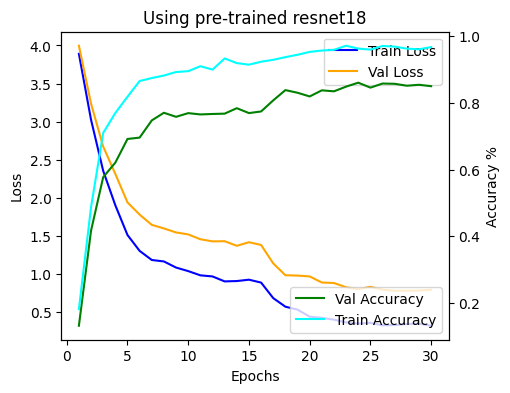

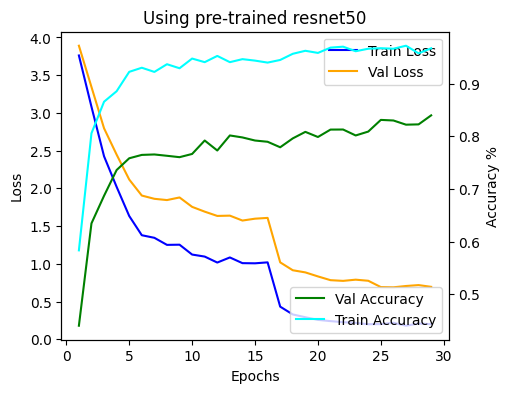

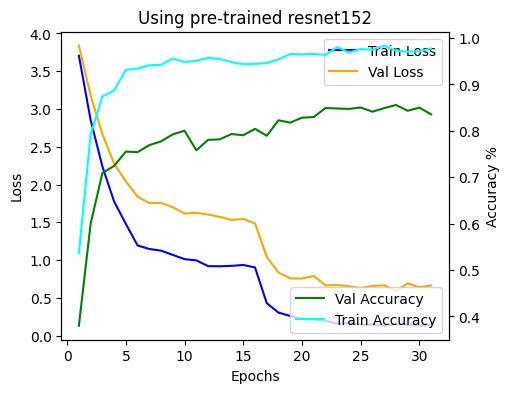

In [ ]:
backbones = ["resnet18", "resnet50", "resnet152"]
train_loader, train_val_loader,  validation_loader, test_loader = get_train_val_test_loader()
transfer_learning_on_backbone(backbones, feature_extract_epochs=16, fine_tune_epochs=16)

# With Mixup

100%|██████████| 344862509/344862509 [00:12<00:00, 28213483.31it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 590780.19it/s]


100%|██████████| 14989/14989 [00:00<00:00, 33405112.99it/s]


Running feature extraction on a resnet18 backbone for 16 epochs.



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


[1] Train Loss: 4.92045
[1] Train Loss: 4.33062, Accuracy: 0.07645
[1] Val Loss: 4.40753, Accuracy: 0.05273
Current valdation accuracy 5.27 is better than previous best of 0.00. Saving checkpoint.
[2] Train Loss: 4.40299
[2] Train Loss: 3.71564, Accuracy: 0.27776
[2] Val Loss: 3.85077, Accuracy: 0.23047
Current valdation accuracy 23.05 is better than previous best of 5.27. Saving checkpoint.
[3] Train Loss: 4.02868
[3] Train Loss: 3.25184, Accuracy: 0.42871
[3] Val Loss: 3.46430, Accuracy: 0.33357
Current valdation accuracy 33.36 is better than previous best of 23.05. Saving checkpoint.
[4] Train Loss: 3.80624
[4] Train Loss: 2.89089, Accuracy: 0.50446
[4] Val Loss: 3.13676, Accuracy: 0.39816
Current valdation accuracy 39.82 is better than previous best of 33.36. Saving checkpoint.
[5] Train Loss: 3.51044
[5] Train Loss: 2.54402, Accuracy: 0.61733
[5] Val Loss: 2.82065, Accuracy: 0.51674
Current valdation accuracy 51.67 is better than previous best of 39.82. Saving checkpoint.
[6] Trai

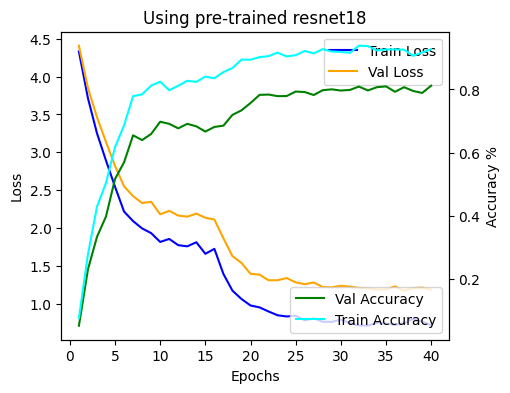

In [7]:
backbones = ["resnet18"]
train_loader, train_val_loader,  validation_loader, test_loader = get_train_val_test_loader(mixup = True)
transfer_learning_on_backbone(backbones, feature_extract_epochs=16, fine_tune_epochs=100)